## Support vector machines

**Data** [Gender-annoted dataset of European parliament talks](https://www.kaggle.com/ellarabi/europarl-annotated-for-speaker-gender-and-age)

**Overreaching question** Can we develop a model which correctly predicts speakers' based on what they are saying?

## Data management

We connect the variable of interest into the textual data each speaker has said.
That data is stored as XML, so we need to do a bit of work before we can easily use it.
Also, transform the textual data to a feature matrix.

In [3]:
metadata_all <- readLines('./data/europarl-annotated-for-speaker-gender-and-age/europarl.de-en/europarl.de-en.dat')
texts_all <- readLines('./data/europarl-annotated-for-speaker-gender-and-age/europarl.de-en/europarl.de-en.en.aligned.tok')

## this time processign these takes already some time, so let's choose a random set of 1000 texts
set.seed(1)

all_ids <- 1:length( metadata_all )
selected_ids <- sample( all_ids, 1000 )


metadata <- metadata_all[ selected_ids ]
texts <- texts_all[ selected_ids ]

In [4]:
require(XML)

clean <- function( entry ){
    xml <- xmlTreeParse( entry )
    return( xmlGetAttr( xml$doc$children$LINE  , "GENDER" ) )
}

gender <- sapply( metadata, FUN = clean )
names( gender ) <- NA

Loading required package: XML



In [5]:
library(quanteda)

corp <- corpus( texts )

token <- tokens( corp )

document_terms <- dfm( token )

Package version: 3.1.0
Unicode version: 13.0
ICU version: 69.1

Parallel computing: 12 of 12 threads used.

See https://quanteda.io for tutorials and examples.



In [6]:
data <- convert( document_terms, "data.frame" )
data$label_for_ml <- as.vector( gender ) ## adding the label we seek to learn to data
data$label_for_ml <- as.factor( data$label_for_ml )
data <- data[, -c(1)] ## this column is added when converting to data frame, but it is useless => remove from analysis

dim( data )

[1] 1000 4059

## Separate the train-test split

This is used later in the analysis to ensure we do not [overfit](https://en.wikipedia.org/wiki/Overfitting) the data when we train the machine learning classifier.
We choose to use 20% of data for testing.

In [7]:
library( caret )

trainIndex <- createDataPartition(data$label_for_ml, p = .8, list = FALSE)

dataTrain <- data[ trainIndex,]
dataTest  <- data[-trainIndex,]

Loading required package: lattice

Loading required package: ggplot2



# Run and evaluate machine learning tasks

We now train the model using the **training** data and measure how well accuracy we achieved by examining **test data**.

In [9]:
model <- train( label_for_ml ~., data = dataTrain, method = "svmLinear")
## this prints a lot of warnings
print( model )

Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x,

Support Vector Machines with Linear Kernel 

 801 samples
4058 predictors
   2 classes: 'FEMALE', 'MALE' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 801, 801, 801, 801, 801, 801, ... 
Resampling results:

  Accuracy   Kappa      
  0.5418977  0.002907022

Tuning parameter 'C' was held constant at a value of 1


In [10]:
test_pred <- predict( model, newdata = dataTest )
postResample( test_pred, as.factor(dataTest$label_for_ml) )

Accuracy      Kappa 
 0.4773869 -0.1316710

           Length Class      Mode     
importance 2      data.frame list     
model      1      -none-     character
calledFrom 1      -none-     character

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'špidla' in 'mbcsToSbcs': dot substituted for <c5>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'špidla' in 'mbcsToSbcs': dot substituted for <a1>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'őry' in 'mbcsToSbcs': dot substituted for <c5>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'őry' in 'mbcsToSbcs': dot substituted for <91>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'băsescu' in 'mbcsToSbcs': dot substituted for <c4>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'băsescu' in 'mbcsToSbcs': dot substituted for <83>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$

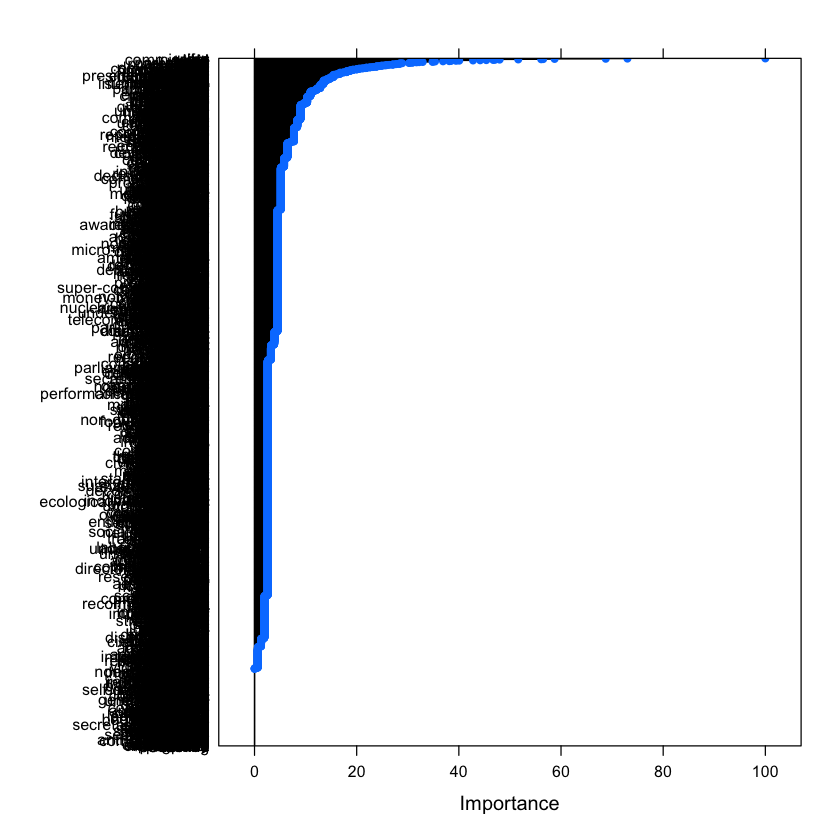

In [11]:
## TODO: Broken :(
importance <- varImp( model, data = dataTest )

summary( importance )
plot( importance )

### Tasks

* Run the code as is and interprent the accuracy. What does that mean?
* Examine different metrics for [classification accuracy](https://topepo.github.io/caret/measuring-performance.html).
* Fix issues in the text pre-processing: account for stop words, frequent terms ans stem content in the document-term-matrix: does it have any implications on accuracy?
* Predictors includes each feature (as a key) and how good the variable was for said problem (as a value). Extract from this the best predictors.
* Count the number of different labels in the dataset of 10,000 comments. What can you observe?
* Modify the code to use [Naive Bayes](https://topepo.github.io/caret/train-models-by-tag.html#bayesian-model) model and SVM model. Which one seems to work better?

# Advanced magics

* There are many different ways to build a models using various supervised machine learning methods.
One can use different parameters of methods. This is known as *tuning* the model and can improve models' performance in terms of accuracy.
* [Grid search](https://topepo.github.io/caret/model-training-and-tuning.html#basic-parameter-tuning) is an approach to examine different parameters and examine what paremeters lead to best models.
* You can also work on data preprocessing to [scale them](https://topepo.github.io/caret/pre-processing.html#centering-and-scaling) or try to more acressively to clean or remove data.

In [12]:
## defining parameters for different models
grid <- expand.grid( "C" = c(1, 10, 100, 1000) )

In [13]:
model <- train( label_for_ml ~., data = dataTrain, method = "svmLinear", tuneGrid = grid )

Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x,

* We have used a binary variable (male/female), however support vector machines can be used to multi-category classification or linear variables through regression models - see [different models](https://topepo.github.io/caret/available-models.html).

* If doing category classification, the algorithm is senstive to inbalances between classification, i.e. if there are more cases belonging to Category 1 than in Category 2. We might need to do [magic](https://topepo.github.io/caret/subsampling-for-class-imbalances.html) to control for these.

In [15]:
library(ROSE)

fixedDataTrain <- ROSE( label_for_ml ~ ., data = dataTrain) ## note: clean out , before running this code

model <- train( label_for_ml ~., data = fixedDataTrain, method = "svmLinear" )
print( model )

Loaded ROSE 0.0-4




ERROR: Error in str2lang(x): <text>:1:29: unexpected ','
1: label_for_ml ~ mr+president+,
                                ^


### Tasks

* Try different grid seaarcg parameters, see if your accuracy metric improve.
* Does balancing improve accuracy with our data?
* Use age variable to develop a regression model.